In [78]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import Model
from sklearn.metrics import accuracy_score
from IPython.core.interactiveshell import InteractiveShell
from contextlib import redirect_stdout, redirect_stderr
import sys

In [79]:
# os.makedirs('testing_without_noise', exist_ok=True)
# os.makedirs('testing_with_noise', exist_ok=True)

In [80]:
# Imbalanced MNIST
def preprocess(dataset, imbalance_factor=0.01):

    ((X_train, Y_train), (X_test, Y_test)) = dataset.load_data()
    X_train_reshaped = X_train.reshape(len(X_train), -1)   
    X_test_reshaped = X_test.reshape(len(X_test), -1)

    X_train_norm = X_train_reshaped / 255            
    X_test_norm = X_test_reshaped / 255

    n_features = X_train_norm.shape[1]
    n_classes = 10

    print('Number of input features (image pixels) : ', n_features)
    print('Number of target classes: ', n_classes)

    Y_train_onehot = to_categorical(Y_train, num_classes=n_classes)
    Y_test_onehot = to_categorical(Y_test, num_classes=n_classes)

    class_1_indices = np.where(Y_train == 1)[0]
    class_2_indices = np.where(Y_train == 2)[0]
    class_3_indices = np.where(Y_train == 3)[0]
    
    class_1_sampled = np.random.choice(class_1_indices, int(len(class_1_indices) * imbalance_factor), replace=False)
    class_2_sampled = np.random.choice(class_2_indices, int(len(class_2_indices) * imbalance_factor), replace=False)
    class_3_sampled = np.random.choice(class_3_indices, int(len(class_3_indices) * imbalance_factor), replace=False)

    other_classes_indices = np.where((Y_train != 1) & (Y_train != 2) & (Y_train != 3))[0]
    selected_indices = np.concatenate([class_1_sampled, class_2_sampled,class_3_sampled, other_classes_indices])

    X_train_imbalance = X_train_norm[selected_indices]
    Y_train_imbalance = Y_train_onehot[selected_indices]

    X_train_final, X_valid, Y_train_final, Y_valid = train_test_split(
        X_train_imbalance, Y_train_imbalance, test_size=0.25, stratify=Y_train_imbalance
    )

    return (n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm, X_train_norm)



def train(n_features, n_classes, model_name):
    model = Sequential()
    model.add(Dense(1000, input_dim = n_features, activation='relu', use_bias=False))

    model.add(Dense(200, activation='relu', use_bias=False))
    model.add(Dense(n_classes, activation='softmax', use_bias=False))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
    # model.summary()
    save_at = str(model_name)
    save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, 
                             save_best_only=True, save_weights_only=False, mode='max')
    return (model,save_best)


def train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best):
    history = model.fit( X_train_final, Y_train_final, 
                        epochs = 10, batch_size = 20, 
                        callbacks=[save_best], verbose=1, 
                        validation_data = (X_valid, Y_valid) )

    plt.figure(figsize=(6, 5))
    plt.plot(history.history['accuracy'], color='r')
    plt.plot(history.history['val_accuracy'], color='b')
    plt.title('Model Accuracy', weight='bold', fontsize=16)
    plt.ylabel('accuracy', weight='bold', fontsize=14)
    plt.xlabel('epoch', weight='bold', fontsize=14)
    plt.ylim(0.5, 1)
    plt.xticks(weight='bold', fontsize=12)
    plt.yticks(weight='bold', fontsize=12)
    plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
    plt.grid(color = 'y', linewidth='0.5')
    plt.show()




def test(model, X_test_norm, Y_test_onehot, verbose=True):
    # Evaluate test accuracy
    score = model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
    test_accuracy = round((score[1] * 100), 2)
    
    if verbose:
        print('Overall accuracy on the test set: ', test_accuracy, '%')
    
    Y_pred_probs = model.predict(X_test_norm, verbose=0)
    Y_pred_classes = np.argmax(Y_pred_probs, axis=1)
    Y_true_classes = np.argmax(Y_test_onehot, axis=1)
    
    class_accuracies = []
    for cls in np.unique(Y_true_classes):
        cls_mask = (Y_true_classes == cls)
        cls_accuracy = accuracy_score(Y_true_classes[cls_mask], Y_pred_classes[cls_mask])
        class_accuracies.append((cls, cls_accuracy * 100))
    
    if verbose:
        print("\nPer-Class Accuracy:")
        for cls, acc in class_accuracies:
            print(f"Class {cls}: {acc:.2f}%")
    print(class_accuracies)
    return test_accuracy, class_accuracies



In [110]:
# pruning%
K = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

def weigh_pruning(X_test_norm, Y_test_onehot, K, trained_model, model_load):

    total_no_layers = len(trained_model.layers)

    all_weights = {}

    for layer_no in range(total_no_layers - 1):
        layer_weights = (pd.DataFrame(trained_model.layers[layer_no].get_weights()[0]).stack()).to_dict() 
        layer_weights = { (layer_no, k[0], k[1]): v for k, v in layer_weights.items() }
        all_weights.update(layer_weights)
    
    all_weights_sorted = {k: v for k, v in sorted(all_weights.items(), key=lambda item: abs(item[1]))}
    total_no_weights = len(all_weights_sorted) 
    print('all_weights',len(all_weights))
    weight_pruning_scores = []

    for pruning_percent in K:

        new_model = load_model(model_load)
        new_weights = trained_model.get_weights().copy()

        prune_fraction = pruning_percent/100
        number_of_weights_to_be_pruned = int(prune_fraction*total_no_weights)
        weights_to_be_pruned = {k: all_weights_sorted[k] for k in list(all_weights_sorted)[ :  number_of_weights_to_be_pruned]}     

        for k, v in weights_to_be_pruned.items():
            new_weights[k[0]][k[1], k[2]] = 0

        for layer_no in range(total_no_layers - 1) :
            new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
            new_model.layers[layer_no].set_weights(new_layer_weights)
        
        new_score  = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
        test(new_model, X_test_norm, Y_test_onehot, verbose=True)
        weight_pruning_scores .append(new_score[1])
    return weight_pruning_scores


def neuron_pruning(X_test_norm, Y_test_onehot, total_no_layers, trained_model, model_load):

    all_neurons = {}

    for layer_no in range(total_no_layers - 1):         

        layer_neurons = {}
        layer_neurons_df = pd.DataFrame(trained_model.layers[layer_no].get_weights()[0])

        for i in range(len(layer_neurons_df.columns)):
            layer_neurons.update({ i : np.array( layer_neurons_df.iloc[:,i] ) })    
                                                                    
        layer_neurons = { (layer_no, k): v for k, v in layer_neurons.items() }
        all_neurons.update(layer_neurons)
    
    all_neurons_sorted = {k: v for k, v in sorted(all_neurons.items(), key=lambda item: np.linalg.norm(item[1], ord=2, axis=0))}
    total_no_neurons = len(all_neurons_sorted) 

    neuron_pruning_scores = []

    for pruning_percent in K:

        new_model = load_model(model_load)
        new_weights = trained_model.get_weights().copy()

        prune_fraction = pruning_percent/100
        number_of_neurons_to_be_pruned = int(prune_fraction*total_no_neurons)
        neurons_to_be_pruned = {k: all_neurons_sorted[k] for k in list(all_neurons_sorted)[ : number_of_neurons_to_be_pruned]}     

        for k, v in neurons_to_be_pruned.items():
            new_weights[k[0]][:, k[1]] = 0

        for layer_no in range(total_no_layers - 1) :
            new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
            new_model.layers[layer_no].set_weights(new_layer_weights)
        
        new_score  = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
        test(new_model, X_test_norm, Y_test_onehot, verbose=True)
        neuron_pruning_scores.append(new_score[1])
    return neuron_pruning_scores

In [82]:
# nc  + std
def compute_gradient_Sw(X_train_norm, Y_train_onehot, trained_model):
    """
    Compute the gradient of the within-class scatter matrix (S_w) for each layer.
    """
    N = X_train_norm.shape[0] 
    output_dim = trained_model.layers[-1].output_shape[1]  
    
    gradient_Sw = {}
    all_weights = {}
    for layer_no, layer in enumerate(trained_model.layers[:-1]):
        if layer_no == 0:  # Only process the first layer
            layer_model = Model(inputs=trained_model.input, outputs=layer.output)
            H_layer_first = layer_model.predict(X_train_norm)
            break

    for layer_no, layer in enumerate(trained_model.layers[:-1]):

        layer_model = Model(inputs=trained_model.input, outputs=layer.output)
        H_layer = layer_model.predict(X_train_norm)
        print(f"Layer {layer_no} activation shape: {H_layer.shape}")

        mu_c = np.zeros((output_dim, H_layer.shape[1]))
        for c in range(output_dim):
            class_samples = H_layer[Y_train_onehot[:, c] == 1]
            mu_c[c] = np.mean(class_samples, axis=0)

        W = layer.get_weights()[0]  
        grad_Sw = np.zeros_like(W)

        for i in range(N):
            for c in range(output_dim):
                if Y_train_onehot[i, c] == 1:
                    if (layer_no==0):
                        h = X_train_norm[i]
                    else:
                 
                        h = H_layer_first[i]
             
                    diff = H_layer[i] - mu_c[c]
                    # print('diff',diff.shape)
                    # print(diff.shape)
                    # print(W.shape)
                    # diff_projected = np.dot(diff, W.T) 
                    # print('diff_projected',diff_projected.shape)
                    grad_Sw += 2 * np.outer(h, diff.T) 

        gradient_Sw[layer_no] = grad_Sw
    return gradient_Sw


def prune_weights_using_Sw(X_test_norm, Y_test_onehot, X_train_norm, Y_train_onehot, K, trained_model, model_load):
    """
    Perform weight pruning using the gradient of the within-class scatter matrix (S_w),
    and rank the weights based on Neural Collapse scores.
    """
    gradient_Sw = compute_gradient_Sw(X_train_norm, Y_train_onehot, trained_model)
    total_no_layers = len(trained_model.layers)
    weight_pruning_scores = []

    all_weights = {}
    all_ranking_scores = {}

    for layer_no in range(total_no_layers - 1):
        if layer_no not in gradient_Sw:
            print(f"Warning: No gradient found for layer {layer_no}. Skipping this layer.")
            continue

        grad_Sw = gradient_Sw[layer_no]
        print(f"Layer {layer_no}: Gradient shape: {grad_Sw.shape}")

        weight_importance = np.linalg.norm(grad_Sw, ord=2)
        
        W = trained_model.layers[layer_no].get_weights()[0] 
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                all_weights[(layer_no, i, j)] = W[i, j]
                all_ranking_scores[(layer_no, i, j)] = np.abs(grad_Sw[i, j])

    all_weights_sorted = {k: v for k, v in sorted(all_ranking_scores.items(), key=lambda item: item[1])}

    total_no_weights = len(all_weights_sorted)
    print(f"Total weights to consider: {total_no_weights}")

    for pruning_percent in K:
    
        new_model = load_model(model_load)
        new_weights = new_model.get_weights().copy()

        prune_fraction = pruning_percent / 100
        number_of_weights_to_be_pruned = int(prune_fraction * total_no_weights)
        weights_to_be_pruned = list(all_weights_sorted.keys())[:number_of_weights_to_be_pruned]

        for k in weights_to_be_pruned:
            layer_no, i, j = k
            new_weights[layer_no][i, j] = 0

        for layer_no in range(total_no_layers - 1):
            new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
            new_model.layers[layer_no].set_weights(new_layer_weights)

        new_score = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
        test(new_model, X_test_norm, Y_test_onehot, verbose=True)
        weight_pruning_scores.append((pruning_percent, new_score[1]))

    return weight_pruning_scores


In [83]:
# # nc  + std
# def compute_gradient_Sw(X_train_norm, Y_train_onehot, trained_model):
#     """
#     Compute the gradient of the within-class scatter matrix (S_w) for each layer.
#     """
#     N = X_train_norm.shape[0] 
#     output_dim = trained_model.layers[-1].output_shape[1]  
    
#     gradient_Sw = {}

#     for layer_no, layer in enumerate(trained_model.layers[:-1]):

#         layer_model = Model(inputs=trained_model.input, outputs=layer.output)
#         H_layer = layer_model.predict(X_train_norm)
#         print(f"Layer {layer_no} activation shape: {H_layer.shape}")

#         mu_c = np.zeros((output_dim, H_layer.shape[1]))
#         for c in range(output_dim):
#             class_samples = H_layer[Y_train_onehot[:, c] == 1]
#             mu_c[c] = np.mean(class_samples, axis=0)

#         W = layer.get_weights()[0]  
#         grad_Sw = np.zeros_like(W)

#         for i in range(N):
#             for c in range(output_dim):
#                 if Y_train_onehot[i, c] == 1:
#                     diff = H_layer[i] - mu_c[c]
#                     diff_projected = np.dot(diff, W.T) 
#                     grad_Sw += 2 * np.outer(diff_projected, diff) 

#         gradient_Sw[layer_no] = grad_Sw
#     return gradient_Sw


# def prune_weights_using_Sw(X_test_norm, Y_test_onehot, X_train_norm, Y_train_onehot, K, trained_model, model_load):
#     """
#     Perform weight pruning using the gradient of the within-class scatter matrix (S_w),
#     and rank the weights based on Neural Collapse scores.
#     """
#     gradient_Sw = compute_gradient_Sw(X_train_norm, Y_train_onehot, trained_model)
#     total_no_layers = len(trained_model.layers)
#     weight_pruning_scores = []

#     all_weights = {}
#     all_ranking_scores = {}

#     for layer_no in range(total_no_layers - 1):
#         if layer_no not in gradient_Sw:
#             print(f"Warning: No gradient found for layer {layer_no}. Skipping this layer.")
#             continue

#         grad_Sw = gradient_Sw[layer_no]
#         print(f"Layer {layer_no}: Gradient shape: {grad_Sw.shape}")

#         weight_importance = np.linalg.norm(grad_Sw, ord=2)
        
#         W = trained_model.layers[layer_no].get_weights()[0] 
#         for i in range(W.shape[0]):
#             for j in range(W.shape[1]):
#                 all_weights[(layer_no, i, j)] = W[i, j]
#                 all_ranking_scores[(layer_no, i, j)] = np.abs(grad_Sw[i, j])

#     all_weights_sorted = {k: v for k, v in sorted(all_ranking_scores.items(), key=lambda item: item[1])}

#     total_no_weights = len(all_weights_sorted)
#     print(f"Total weights to consider: {total_no_weights}")

#     for pruning_percent in K:
    
#         new_model = load_model(model_load)
#         new_weights = new_model.get_weights().copy()

#         prune_fraction = pruning_percent / 100
#         number_of_weights_to_be_pruned = int(prune_fraction * total_no_weights)
#         weights_to_be_pruned = list(all_weights_sorted.keys())[:number_of_weights_to_be_pruned]

#         for k in weights_to_be_pruned:
#             layer_no, i, j = k
#             new_weights[layer_no][i, j] = 0

#         for layer_no in range(total_no_layers - 1):
#             new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
#             new_model.layers[layer_no].set_weights(new_layer_weights)

#         new_score = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
#         test(new_model, X_test_norm, Y_test_onehot, verbose=True)
#         weight_pruning_scores.append((pruning_percent, new_score[1]))

#     return weight_pruning_scores


In [117]:
def plots(standard_w, standard__neuron, nc, imbalance):
    plt.figure(figsize=(8, 4))
    plt.plot(pd.DataFrame(standard_w).set_index(pd.Series(K), drop=True), color='r', marker='o', markersize=3,linewidth=1)
    plt.plot(pd.DataFrame(standard__neuron).set_index(pd.Series(K), drop=True), color='g', marker='s', markersize=3,linewidth=1)
    plt.plot(pd.DataFrame(nc).set_index(pd.Series(K), drop=True), color='b', marker='^', markersize=3,linewidth=1)
    plt.title('Effect of Pruning on Accuracy (Balance = ' + imbalance + ')', fontsize=10)
    plt.ylabel('Accuracy', fontsize=8)
    plt.xlabel('Pruning Percentage', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=8)
    plt.ylim(0, 1)
    plt.legend(['Weigh Pruning', 'Neuron Pruning', 'NC Pruning'], loc='best', prop={'size': 8})
    plt.grid(color='gray', linestyle='-', linewidth=0.3)
    filename = f"testing_with_noise/{imbalance}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# without noise + log file

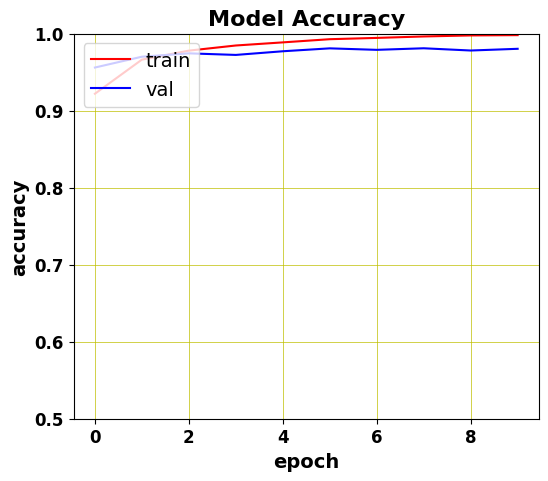

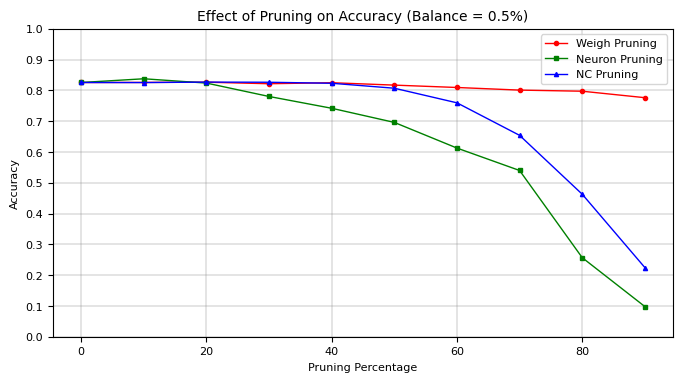

Output saved to logs/testing_without_noise/balance_0.5%_output.log


In [116]:
log_dir = "logs/testing_without_noise"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


output_log_file = os.path.join(log_dir, "balance_0.5%_output.log")

if os.path.exists(output_log_file):
    open(output_log_file, 'w').close()

with open(output_log_file, 'a') as log_file:
    with redirect_stdout(log_file), redirect_stderr(log_file):
        n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm, X_train_norm = preprocess(mnist, imbalance_factor=0.005)
        model, save_best = train(n_features, n_classes, 'mnist.hdf5')
        train_plots(model, X_train_final, Y_train_final, X_valid, Y_valid, save_best)
        test(model, X_test_norm, Y_test_onehot)
        trained_model = load_model("mnist.hdf5")
        total_no_layers = len(trained_model.layers)
        print('Starting neuron pruning')
        neuron_pruning_scores = neuron_pruning(X_test_norm, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
        print('Starting weight pruning using nc')
        weight_pruning_scores_nc = prune_weights_using_Sw(X_test_norm, Y_test_onehot, X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
        print('Starting weight pruning')
        weight_pruning_scores = weigh_pruning(X_test_norm, Y_test_onehot, K, trained_model, 'mnist.hdf5')
        plots(weight_pruning_scores, neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)), '0.5%')

print(f"Output saved to {output_log_file}")


#noisy data

In [118]:
def noise(dataset, noise_factor=0.2):
    ((X_train, Y_train), (X_test, Y_test)) = dataset.load_data()
    
    # Reshape the data
    X_train_reshaped = X_train.reshape(len(X_train), -1)   
    X_test_reshaped = X_test.reshape(len(X_test), -1)

    # Normalize the images by dividing by 255
    X_train_norm = X_train_reshaped / 255            
    X_test_norm = X_test_reshaped / 255

    # Add Gaussian noise to the data
    noise_train = np.random.normal(0, noise_factor, X_train_norm.shape)
    noise_test = np.random.normal(0, noise_factor, X_test_norm.shape)
    
    X_train_noisy = X_train_norm + noise_train
    X_test_noisy = X_test_norm + noise_test

    # Ensure pixel values remain between 0 and 1
    X_train_noisy = np.clip(X_train_noisy, 0, 1)
    X_test_noisy = np.clip(X_test_noisy, 0, 1)

    # Get the number of features and classes
    n_features = X_train_noisy.shape[1]
    n_classes = 10
    Y_train_onehot = to_categorical(Y_train, num_classes=n_classes)
    Y_test_onehot = to_categorical(Y_test, num_classes=n_classes)

    return X_test_noisy, Y_test_onehot



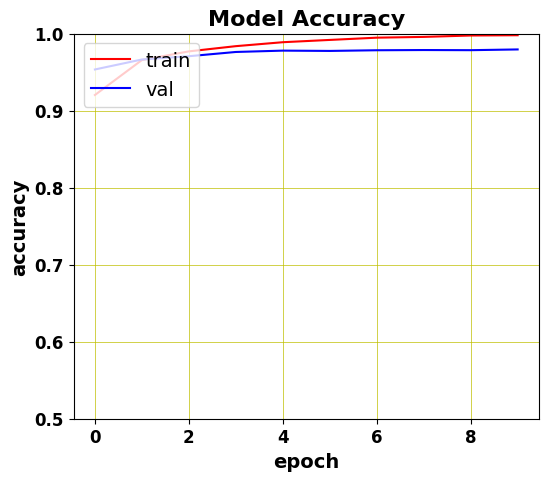

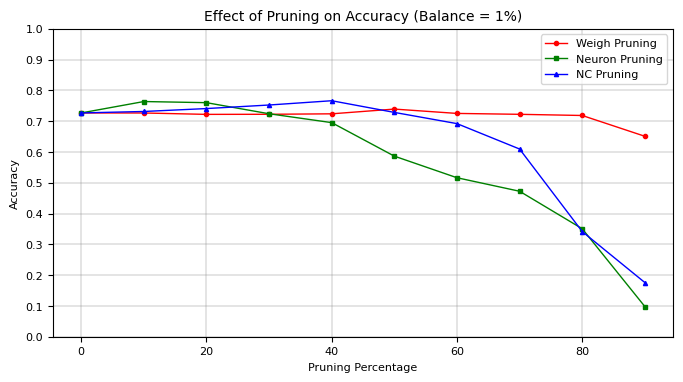

Output saved to logs/testing_with_noise/balance_1%_output.log


In [122]:
log_dir = "logs/testing_with_noise"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


output_log_file = os.path.join(log_dir, "balance_1%_output.log")

if os.path.exists(output_log_file):
    open(output_log_file, 'w').close()

with open(output_log_file, 'a') as log_file:
    with redirect_stdout(log_file), redirect_stderr(log_file):
        n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.01)
        model,save_best = train(n_features, n_classes, 'mnist.hdf5')
        train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
        X_test_noisy,Y_test_onehot = noise(mnist)
        test(model, X_test_noisy, Y_test_onehot)
        trained_model = load_model("mnist.hdf5")
        total_no_layers = len(trained_model.layers)
        neuron_pruning_scores = neuron_pruning(X_test_noisy, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
        weight_pruning_scores_nc = prune_weights_using_Sw(X_test_noisy, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
        weight_pruning_scores = weigh_pruning(X_test_noisy, Y_test_onehot, K, trained_model, 'mnist.hdf5')

        plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'1%')

print(f"Output saved to {output_log_file}")


Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1000)              784000    
                                                                 
 dense_19 (Dense)            (None, 200)               200000    
                                                                 
 dense_20 (Dense)            (None, 10)                2000      
                                                                 
Total params: 986000 (3.76 MB)
Trainable params: 986000 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1580/1580 [==============================] - 4s 3ms/step - loss: 0.3211 - accuracy: 0.9159 - val_loss: 0.1765 - val_accuracy: 0.9473
Epoch 2/10
  72/1580 [>.............................] - ETA: 3s - loss: 0.1548 - accuracy: 0.9576

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1580/1580 [==============================] - 4s 2ms/step - loss: 0.1300 - accuracy: 0.9629 - val_loss: 0.1243 - val_accuracy: 0.9617
Epoch 3/10
1580/1580 [==============================] - 4s 3ms/step - loss: 0.0878 - accuracy: 0.9753 - val_loss: 0.1028 - val_accuracy: 0.9676
Epoch 4/10
1580/1580 [==============================] - 4s 3ms/step - loss: 0.0629 - accuracy: 0.9825 - val_loss: 0.0816 - val_accuracy: 0.9749
Epoch 5/10
1580/1580 [==============================] - 4s 2ms/step - loss: 0.0456 - accuracy: 0.9879 - val_loss: 0.0789 - val_accuracy: 0.9754
Epoch 6/10
1580/1580 [==============================] - 4s 2ms/step - loss: 0.0334 - accuracy: 0.9905 - val_loss: 0.0751 - val_accuracy: 0.9766
Epoch 7/10
1580/1580 [==============================] - 4s 2ms/step - loss: 0.0241 - accuracy: 0.9935 - val_loss: 0.0718 - val_accuracy: 0.9780
Epoch 8/10
1580/1580 [==============================] - 4s 2ms/step - loss: 0.0163 - accuracy: 0.9964 - val_loss: 0.0723 - val_accuracy: 0.9782
Epo

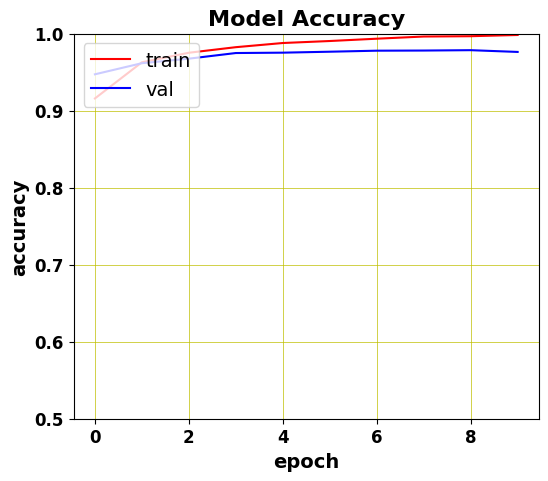

Overall accuracy on the test set:  87.65 %

Per-Class Accuracy:
Class 0: 97.04%
Class 1: 75.42%
Class 2: 92.93%
Class 3: 85.84%
Class 4: 70.77%
Class 5: 94.84%
Class 6: 99.16%
Class 7: 95.53%
Class 8: 95.69%
Class 9: 72.05%
[(0, 97.0408163265306), (1, 75.41850220264317), (2, 92.92635658914729), (3, 85.84158415841584), (4, 70.77393075356414), (5, 94.84304932735425), (6, 99.16492693110646), (7, 95.52529182879378), (8, 95.68788501026694), (9, 72.05153617443013)]
Overall accuracy on the test set:  86.92 %

Per-Class Accuracy:
Class 0: 98.78%
Class 1: 63.79%
Class 2: 90.50%
Class 3: 84.75%
Class 4: 80.75%
Class 5: 93.50%
Class 6: 97.18%
Class 7: 96.21%
Class 8: 98.15%
Class 9: 70.07%
[(0, 98.77551020408163), (1, 63.7885462555066), (2, 90.50387596899225), (3, 84.75247524752476), (4, 80.75356415478615), (5, 93.49775784753363), (6, 97.18162839248434), (7, 96.20622568093385), (8, 98.15195071868584), (9, 70.06937561942517)]
Overall accuracy on the test set:  87.69 %

Per-Class Accuracy:
Class 0:

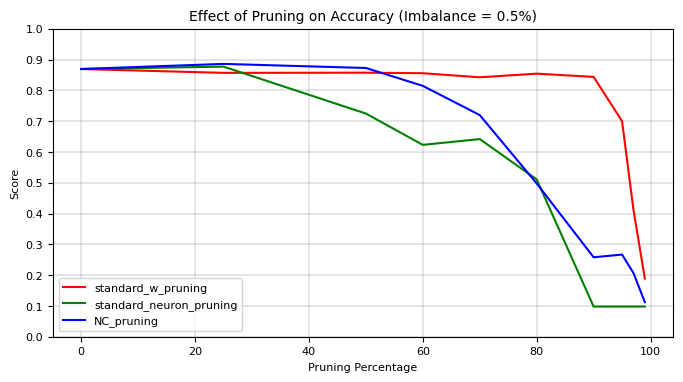

In [ ]:
n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.05)
model,save_best = train(n_features, n_classes, 'mnist.hdf5')
train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
X_test_noisy,Y_test_onehot = noise(mnist)
test(model, X_test_noisy, Y_test_onehot)
trained_model = load_model("mnist.hdf5")
total_no_layers = len(trained_model.layers)
neuron_pruning_scores = neuron_pruning(X_test_noisy, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
weight_pruning_scores_nc = prune_weights_using_Sw(X_test_noisy, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
weight_pruning_scores = weigh_pruning(X_test_noisy, Y_test_onehot, K, trained_model, 'mnist.hdf5')

plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'0.5%')